# Тестирование двойственного алгоритма решения задачи минимизации максимального запаздывания

### What's new
- Во время поиска оптимального примера в множестве $N$ критерий поиска изменён с $min\:\nu$ на $min\:max(\nu_{N}, L_{max}(\pi))$
- Когда присоставлении оптимального расписания ведётся поиск примера с минимальной оценкой $max(\nu_{N}, L_{max}(\pi))$, приоритет отдаётся примерам с наиболее длинным $\pi$

### Импорты

In [57]:
import time
import sys
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations
from scipy.optimize import curve_fit

### Парсинг примеров

In [342]:
def parse_str(s):
    s = np.array(s.replace(',', ' ').split(), dtype=int)
    s = s.reshape((len(s)//3, 3))
    return s

### Класс "Расписание"

In [226]:
class Schedule:
    """
    A wrap around arrays of shape (n, 3), 
    where n is the number of jobs in the schedule
    and each job parameters are ordered as follows:
    r | p | d
    """
    array = None
    
    def enum(self):
        if len(self.array) > 0:
            a = np.append(self.array, np.ones((len(self.array), 1)), axis=1)
            for i, _ in enumerate(a):
                a[i, 3] += i
            self.array = a.astype(int)
    
    def __init__(self, array, Enumerate=False):
        """
        Arguments:
        - array: int or list/np.ndarray
        if int, the schedule is generated randomly and contains n elements
        if list/np.ndarray/etc., the array is directly transformed into schedule
        """
        if isinstance(array, int):
            self.array = np.random.randint(1, 1000, size=(array, 3))
            self.array[:,2] = self.array[:,2] + self.array[:,1] + self.array[:,0] # for non-negative time slack
        else: self.array = np.copy(array)
        if Enumerate: self.enum()
    
    def show(self):
        print(" r  |  p  |  d  | num ")
        print(self.array)
        
    def sort(self, item=0):
        self.array = self.array[self.array[:,item].argsort()]
        
    def remove(self, B):
        idx = []
        for i, e in enumerate(np.isin(self.array, B)):
            if e.all():
                idx.append(i)
        self.array = np.delete(self.array, idx, axis=0)
    
    def pop(self, index=-1):
        e = self.array[index]
        self.array = np.delete(self.array, index, axis=0)
        return e
    
    def copy(self):
        return Schedule(np.copy(self.array))
    
    def insert(self, index, elem):
        self.array = np.insert(self.array, index, elem, axis=0)
        
    def length(self):
        return self.array.shape[0]
    
    def C(self, j=None):
        t = 0
        for task in self.array[:j]:
            if t < task[0]:
                t = task[0]
            t += task[1]
        return t
    
    def timeshift(self, tau):
        for i in range(self.length()):
            self.array[i,0] -= tau
            
    def L_max(self, tau=0):
        if len(self.array) == 0:
            return float('inf')
        a = self.copy()
        a.timeshift(tau)
        return max([self.C(j+1) - a.array[j,2] for j in range(len(a.array))]) + tau


### Алгоритм решения двойственной задачи

In [266]:
def dual(N, tau, B):
    pi_r = N.copy()
    pi_r.remove(B)
    pi_r.timeshift(tau)
    pi_r.sort()
    bestC = pi_r.C()
    bestI = 0
    # todo: set the condition
    if True:
        for k, e in enumerate(pi_r.array):
            pi_k = pi_r.copy()
            i_k = pi_k.pop(k)
            if pi_k.length() > 0:
                i_l = pi_k.pop(np.argmin(pi_k.array, axis=0)[0])
                pi_k.insert(pi_k.length(), i_k)
                pi_k.insert(0, i_l)
                C_k = pi_k.C()
                if C_k < bestC:
                    print("CH!")
                    bestC = C_k
                    bestI = k
        return bestC + tau, bestI
        

### Класс "пример"
Содержит все параметры примера, указанные в статье: $N,\tau, \nu, \pi, B$, при чём $\nu$ автоматически вычисляется применением двойственного алгоритма к $N$

In [89]:
class Instance:
    
    def __init__(self, N, tau, pi=Schedule([]), B=[]):
        """
        Arguments:
        - N - Schedule object
        - tau - int or (possibly) float
        - pi - Schedule object
        - B - list
        """
        self.N = N.copy()
        self.tau = tau
        self.nu = dual(N, tau, B)[0]
        self.pi = pi.copy()
        self.B = B.copy()
        
    def best_job(self):
        N1 = self.N.copy()
        N1.remove(self.B)
        if len(N1.array) == 0:
            return
        a = N1.array[N1.array[:,0] <= self.tau]
        if len(a) == 0:
            self.tau = np.min(N1.array[:,0], axis=0)
            a = N1.array[N1.array[:,0] <= self.tau]
        f = min(a, key=lambda x: x[2])
        return f

### Алгоритм решения задачи $1|r_j|L_{max}$

In [284]:
# timeout parameter sets maximum calculation time limit in seconds for one schedule
timeout = 1200

def main(N, tau=0):
    #tb = time.time() - !таймаут отключен!
    c = 0
    bestPi = Schedule([])    
    instances = [Instance(N, tau)]
    while len(instances) > 0:
        #ti = time.time()
        #if ti - tb > timeout:
        #    return Schedule([]), -1
        index, instance = min(enumerate(instances), key=lambda x: max(x[1].nu, x[1].pi.L_max()) - x[1].pi.length()/N.length()/10)
        f = instance.best_job()
        instances.pop(index)
        if f is not None:

            N1 = instance.N.copy()
            N1.remove(f)
            tau1 = max(f[0], instance.tau) + f[1]
            B1 = []
            a1 = np.copy(instance.pi.array)
            if len(a1) == 0:
                a1 = np.copy([f,])
            else:
                a1 = np.append(a1, [f,], axis=0)
            pi1 = Schedule(a1)
            i1 = Instance(N1, tau1, pi1, B1)

            N2 = instance.N
            tau2 = instance.tau
            if len(instance.B) == 0:
                B2 = np.copy([f,])
            else:
                B2 = np.append(instance.B, [f,], axis=0)
            pi2 = instance.pi
            i2 = Instance(N2, tau2, pi2, B2)

            instances += [i1, i2]
            c += 1
            #pi1.show()
            if pi1.length() == N.length():
                if pi1.L_max(tau) < bestPi.L_max(tau):
                    bestPi = pi1.copy()
            #print("instance nu: %s\ni1 nu: %s\ni2 nu: %s" % (instance.nu, i1.nu, i2.nu))
            #print("Lmax:", bestPi.L_max(tau))
            instances = [i for i in instances if i.nu < bestPi.L_max(tau)]

    return bestPi, c

### Алгоритм перебора *всех* возможных вариантов

In [263]:
def bruteforce(S, tau=0):
    N = np.copy(S.array)
    best_L = Schedule(N).L_max(tau)
    best_S = N
    for p in permutations(N):
        L = Schedule(p).L_max(tau)
        if L < best_L:
            best_L = L
            best_S = p
    return Schedule(best_S)

# Тестирование

### Подсчёт корректности работы алгоритма на примерах малой размерности
**Количество задач в примере:** от 2 до 10

**Количество примеров каждой размерности:** 50

При этом решение, предложенное алгоритмом, сравнивается с решением, полученным методом перебора всех возможных вариантов

In [285]:
tc = 0 # true counter - when the result is correct
fc = 0 # false counter - when the result is incorrect
xc = []
yc = []
for n in range(2, 16):
    for i in range(50):
        print('\r', i, end='')
        t = 0
        s = Schedule(n)
        result, count = main(s, t)
        result = result.L_max(t)
        realResult = bruteforce(s, t).L_max(t)
        if result == realResult:
            tc += 1
        else:
            fc += 1
    xc.append(n)
    yc.append(tc/(tc + fc)*100)
    print(" --", n, "tasks", end='')
    print("\t Correct: %d%%\tIncorrect: %d%%" % (tc/(tc + fc)*100, fc/(tc + fc)*100))
    tc = 0
    fc = 0
rresults = [xc, yc]
json.dump(rresults, open('rresults1112.json', 'w'))

 49 -- 2 tasks	 Correct: 88%	Incorrect: 12%
 49 -- 3 tasks	 Correct: 72%	Incorrect: 28%
 49 -- 4 tasks	 Correct: 74%	Incorrect: 26%
 49 -- 5 tasks	 Correct: 68%	Incorrect: 32%
 49 -- 6 tasks	 Correct: 96%	Incorrect: 4%
 49 -- 7 tasks	 Correct: 98%	Incorrect: 2%
 49 -- 8 tasks	 Correct: 96%	Incorrect: 4%
 49 -- 9 tasks	 Correct: 100%	Incorrect: 0%
 49 -- 10 tasks	 Correct: 100%	Incorrect: 0%
 6

KeyboardInterrupt: 

Text(0, 0.5, 'Процент верно решённых примеров')

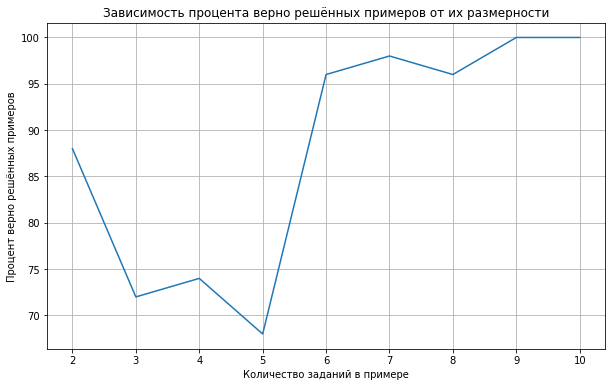

In [288]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, title='Зависимость процента верно решённых примеров от их размерности')
ax.grid()
ax.plot(xc, yc)
ax.set_xlabel("Количество заданий в примере")
ax.set_ylabel("Процент верно решённых примеров")
#ax.plot(x, y, alpha=0.5)

### Оценка сложности алгоритма
Метрика - количество узлов ветвления

**Размерность примеров:** от 2 до 100

**Количество примеров каждой размерности:** 10

In [289]:
results = dict()
for n in range(10, 101, 5):
    results[n] = []
    for i in range(10):
        print('\r', len(results[n]), end='')
        t = 0
        s = Schedule(n)
        result, count = main(s, t)
        results[n].append(count)
    print(" --", n, "tasks")
    
    json.dump(results, open('results77new.json', 'w'))

 9 -- 10 tasks
 9 -- 15 tasks
 9 -- 20 tasks
 9 -- 25 tasks
 9 -- 30 tasks
 9 -- 35 tasks
 9 -- 40 tasks
 9 -- 45 tasks
 9 -- 50 tasks
 9 -- 55 tasks
 9 -- 60 tasks
 9 -- 65 tasks
 9 -- 70 tasks
 9 -- 75 tasks
 9 -- 80 tasks
 9 -- 85 tasks
 9 -- 90 tasks
 9 -- 95 tasks
 3

KeyboardInterrupt: 

### Примеры малой размерности

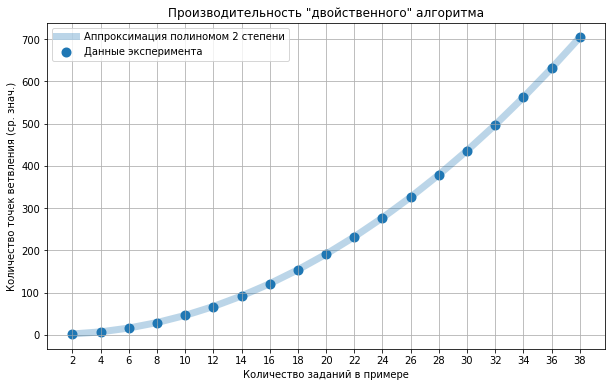

In [328]:
x = []
y = []
#yf = []
for k in results2.keys():
    y.append(np.median(results2[k]))
    x.append(k)
    #yf.append(np.math.factorial(k))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, title='Производительность "двойственного" алгоритма')
ax.grid()
ax.scatter(x, y, linewidth=4, label="Данные эксперимента")
ax.set_xlabel("Количество заданий в примере")
ax.set_ylabel("Количество точек ветвления (ср. знач.)")
i = 1
ax.plot(x, z[i](list(map(int, x))), label='Аппроксимация полиномом %s степени' % (i+1), linewidth=7, alpha=0.3)
ax.legend()

### Примеры большой размерности

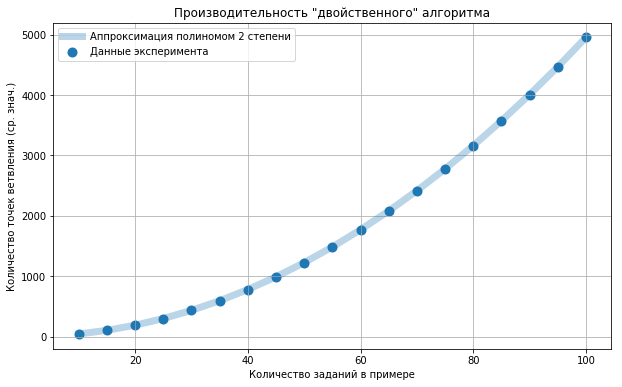

In [311]:
x = []
y = []
yf = []
for k in results.keys():
    y.append(np.median(results[k]))
    x.append(k)
    yf.append(np.math.factorial(k))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, title='Производительность "двойственного" алгоритма')
ax.grid()
ax.scatter(x, y, linewidth=4, label="Данные эксперимента")
ax.set_xlabel("Количество заданий в примере")
ax.set_ylabel("Количество точек ветвления (ср. знач.)")
i = 1
ax.plot(x, z[1](x), label='Аппроксимация полиномом %s степени' % (i+1), linewidth=7, alpha=0.3)
ax.legend()

In [329]:
def approx(x, y, i):
    """
    Parameters:
     - x - x values list
     - y - y values list
     - i - polynome power
    Returns:
     numpy poly1d function
    """
    return np.poly1d(np.polyfit(list(map(float, x)), list(map(float, y)), i))

# Тестирование на "трудных" примерах
Ниже представлены решения, полученные данным алгоритмом для [примеров SiPSi](https://sites.google.com/site/shunjitanaka/sips/benchmark-results-sipsi) размерности $n = 10$.

In [399]:
import glob
schedules = []
for fname in glob.glob("./wtr10/*.dat"):
    file = open(fname, 'r')
    file.seek(0)
    a = np.array(list(f.split() for f in file.readlines()[6:]))[:, :3].astype(int)
    s = Schedule(a, Enumerate=True)
    # replacing r and p columns
    r = s.array[:, 1].copy()
    p = s.array[:, 0].copy()
    s.array[:, 1] = p
    s.array[:, 0] = r
    schedules.append(s)
    file.close()

Вывод решений и значений $L_{max}$ для них

In [405]:
for s in schedules:
    res, n = main(s)
    res.show()
    print(res.L_max())

 r  |  p  |  d  | num 
[[  0  20  32   6]
 [  0  34  37   7]
 [  0  40  47   2]
 [  0  28  57   9]
 [  0  56  62  10]
 [  0  77  80   8]
 [  0  79  83   3]
 [  0  85  85   1]
 [  0  92  96   5]
 [  0  80 104   4]]
487
 r  |  p  |  d  | num 
[[  0   7  22   9]
 [  0  29  37   5]
 [  0  36  52   6]
 [  0  53  60   1]
 [  0  41  68   3]
 [  0  81  92   7]
 [  0  77 107   2]
 [  0  92 115   8]
 [  0  95 115  10]
 [  0  90 116   4]]
485
 r  |  p  |  d  | num 
[[  0  17  23   2]
 [  0  23  40   7]
 [  0  36  53   9]
 [  0  34  58   6]
 [  0  45  71   3]
 [  0  69  76  10]
 [  0  69  82   1]
 [  0  83  87   5]
 [  0  90 102   8]
 [  0  89 114   4]]
441
 r  |  p  |  d  | num 
[[  0  11  13   1]
 [  0  13  40   2]
 [  0  50  51   3]
 [  0  39  60   8]
 [  0  37  65  10]
 [  0  77  92   4]
 [  0  69  92   7]
 [  0  75  94   9]
 [  0  94 100   6]
 [  0  99 104   5]]
460
 r  |  p  |  d  | num 
[[  0   6  20   3]
 [  0  21  23   6]
 [  0  16  27   4]
 [  0   6  30  10]
 [  0  13  31   8]
 [  0  58 

 r  |  p  |  d  | num 
[[  7  31  57   2]
 [ 13  43  75   8]
 [ 35  65 106   4]
 [118  17 135   3]
 [127  17 148   1]
 [132  11 163   7]
 [120  66 199   5]
 [128  58 203   6]
 [152  96 269  10]
 [221  48 291   9]]
168
 r  |  p  |  d  | num 
[[  2  28  58   1]
 [ 42   9  78   4]
 [ 51  45 133   8]
 [ 52   5 100   2]
 [ 79  15 101   5]
 [ 48   8 134   6]
 [ 79  50 164   9]
 [ 69  29 189   7]
 [ 48  90 230  10]
 [184 100 326   3]]
67
 r  |  p  |  d  | num 
[[  2  33 135   3]
 [ 30  55 128  10]
 [ 22  74 160   6]
 [125   2 193   9]
 [ 82  63 270   2]
 [123  91 284   1]
 [158  85 298   5]
 [149  22 299   8]
 [195  14 303   7]
 [242  88 402   4]]
138
 r  |  p  |  d  | num 
[[  4  53 111  10]
 [ 24  49 175   2]
 [ 84  15 135   8]
 [118   5 175   7]
 [  6  97 177   4]
 [109  41 198   3]
 [150  41 218   5]
 [ 60  96 236   1]
 [199  58 269   9]
 [206   1 287   6]]
190
 r  |  p  |  d  | num 
[[ 65  78 245   2]
 [ 95  32 179   8]
 [ 85  54 245   9]
 [131  98 247   7]
 [ 95  61 270   1]
 [215   8 3

 r  |  p  |  d  | num 
[[  5   9  33   9]
 [ 60  85 207   6]
 [135  42 218  10]
 [163  25 211   4]
 [212  22 292   1]
 [218  12 283   7]
 [211  31 333   5]
 [260  71 362   2]
 [331  68 481   8]
 [355  16 450   3]]
1
 r  |  p  |  d  | num 
[[ 30  21  77   1]
 [ 42  21 137   3]
 [ 52  47 166   6]
 [ 51  73 211   7]
 [187  63 440   8]
 [389  73 672   9]
 [502  89 872   5]
 [527  36 640   4]
 [513  74 652  10]
 [524  70 785   2]]
49
 r  |  p  |  d  | num 
[[ 76  52 301   8]
 [152  14 416   6]
 [157  25 348   3]
 [229  77 407   1]
 [306  50 599   2]
 [361  62 575  10]
 [372  84 537   4]
 [455  43 505   5]
 [502  93 625   7]
 [519  47 824   9]]
45
 r  |  p  |  d  | num 
[[  0  10  58   5]
 [ 36   2 140   8]
 [ 42  60 132  10]
 [ 60  65 156   7]
 [ 44  34 211   9]
 [ 87  37 238   4]
 [160  20 239   6]
 [222  42 279   2]
 [151  37 320   3]
 [211   8 324   1]]
21
 r  |  p  |  d  | num 
[[ 16  65 314  10]
 [ 23   6  86   6]
 [ 93  51 205   7]
 [272  66 573   5]
 [339  17 395   9]
 [360   6 598  

 r  |  p  |  d  | num 
[[151  36 300   9]
 [177  74 542   2]
 [249  36 306   4]
 [319  81 598   1]
 [402  53 501   8]
 [478  80 767   3]
 [561  70 651   6]
 [570  54 834  10]
 [656  67 930   5]
 [740  41 829   7]]
-9


# Итоги и выводы
1. На примерах малой размерности была протестирована корректность работы алгоритма. Более 90% примеров решаются им правильно.
2. Доля верно решённых примеров растёт с ростом их размерности *(почему?)*
3. Была оценена производительность алгоритма. В качестве метрики использовалось число точек ветвления.
4. С помощью алгоритма решены примеры, использовавшиеся для бэнчмарка SiPSi.